# Ion Temperature Gradient Drift Dispersion (Kappa Distribution)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plasmapy
from scipy import special as sp
import scipy.optimize as op
from tqdm import tqdm
import matplotlib.colors as colors
%config InlineBackend.figure_format = 'svg'

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

In [3]:
mi2me = 1836
ve2vi = 150
vn2vi = 0
L_t2rho_i = 10
wp_i2wc_i = 100

kappa_e = 3
kappa_i = 3
fke = np.sqrt(kappa_e/(kappa_e-0.5))
fki = np.sqrt(kappa_i/(kappa_i-0.5))

print('Te/Ti')
print('M',ve2vi**2/mi2me)
print('MK',ve2vi**2/mi2me*(kappa_i-3/2)/kappa_i)
print('KK',ve2vi**2/mi2me*(kappa_i-3/2)/(kappa_e-3/2)*kappa_e/kappa_i)

Te/Ti
M 12.254901960784315
MK 6.127450980392157
KK 12.254901960784315


In [4]:
terms = 300 # number of terms for the integration
gl_1 = sp.roots_genlaguerre(terms,kappa_i-0.5)
gl_2 = sp.roots_genlaguerre(terms,kappa_i-1.5)
gl_e = sp.roots_genlaguerre(terms,kappa_e-0.5)

def PDRM(w2wc,ky_rho_i,kz_rho_i):
    ky2kz = ky_rho_i/kz_rho_i
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i
    k_l_De = k_l_Di*ve2vi/np.sqrt(mi2me)
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    zeta_ni = 0
    zeta_ti = ky2kz/L_t2rho_i/np.sqrt(2)
    g0 = sp.ive(0,ky_rho_i**2)
    g1 = sp.ive(1,ky_rho_i**2)
    
    re = 1 + (zeta_e)*plasmapy.dispersion.plasma_dispersion_func(zeta_e)*sp.ive(0,ky_rho_e**2)
    ri1 = (zeta_i-zeta_ni+0.5*zeta_ti)*plasmapy.dispersion.plasma_dispersion_func(zeta_i)*g0
    ri2 = zeta_ti*(0.5*zeta_i*plasmapy.dispersion.plasma_dispersion_func_deriv(zeta_i)*g0-plasmapy.dispersion.plasma_dispersion_func(zeta_i)*ky_rho_i**2*(g1-g0))
    ri = 1.0 + ri1 + ri2
    r =  1.0 + re/k_l_De**2 + ri/k_l_Di**2
    return [r.real,r.imag]

def PDRMK(w2wc,ky_rho_i,kz_rho_i):
    ky2kz = ky_rho_i/kz_rho_i
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i*fki
    k_l_De = k_l_Di*ve2vi/np.sqrt(mi2me)/fki
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    zeta_ni = 0
    zeta_ti = 1.0/np.sqrt(2)*ky2kz/L_t2rho_i*kappa_i/(kappa_i-1.5)

    K1_integrad = lambda bi: np.sqrt(bi) * ( zeta_i - zeta_ni*(kappa_i-3/2)/kappa_i/bi + 0.5*zeta_ti*(kappa_i-3/2)/kappa_i/bi )*plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi))*sp.ive(0,ky_rho_i**2/bi)

    K2_integrad = lambda bi: zeta_ti * ( 0.5*zeta_i*bi*plasmapy.dispersion.plasma_dispersion_func_deriv(zeta_i*np.sqrt(bi))*sp.ive(0,ky_rho_i**2/bi) - plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi)) * ky_rho_i**2/np.sqrt(bi) * (sp.ive(1,ky_rho_i**2/bi)-sp.ive(0,ky_rho_i**2/bi)) )

    ri1 =  np.dot(gl_1[1],K1_integrad(gl_1[0]/kappa_i))/sp.gamma(kappa_i+0.5)
    ri2 =  np.dot(gl_2[1],K2_integrad(gl_2[0]/kappa_i))/sp.gamma(kappa_i+0.5)*(kappa_i-1.5)

    re = 1 + (zeta_e)*plasmapy.dispersion.plasma_dispersion_func(zeta_e)*sp.ive(0,ky_rho_e**2)
    ri = 1.0 + ri1 + ri2
    r =  1.0 + re/k_l_De**2 + ri/k_l_Di**2

    return [r.real,r.imag]

def PDRKM(w2wc,ky_rho_i,kz_rho_i):
    ky2kz = ky_rho_i/kz_rho_i
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i
    k_l_De = k_l_Di*ve2vi/np.sqrt(mi2me)*fke
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    zeta_ni = 0
    zeta_ti = 1.0/np.sqrt(2)*ky2kz/L_t2rho_i

    g0 = sp.ive(0,ky_rho_i**2)
    g1 = sp.ive(1,ky_rho_i**2)

    Ke_integrad = lambda be: np.sqrt(be) * zeta_e * plasmapy.dispersion.plasma_dispersion_func(zeta_e*np.sqrt(be))*sp.ive(0,ky_rho_e**2/be)
    re = 1.0 + np.dot(gl_e[1],Ke_integrad(gl_e[0]/kappa_e))/sp.gamma(kappa_e+0.5)

    ri1 = (zeta_i-zeta_ni+0.5*zeta_ti)*plasmapy.dispersion.plasma_dispersion_func(zeta_i)*g0
    ri2 = zeta_ti*(0.5*zeta_i*plasmapy.dispersion.plasma_dispersion_func_deriv(zeta_i)*g0-plasmapy.dispersion.plasma_dispersion_func(zeta_i)*ky_rho_i**2*(g1-g0))
    ri = 1.0 + ri1 + ri2

    r =  1.0 + re/k_l_De**2 + ri/k_l_Di**2

    return [r.real,r.imag]

def PDRK(w2wc,ky_rho_i,kz_rho_i):
    ky2kz = ky_rho_i/kz_rho_i
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i*fki
    k_l_De = k_l_Di*ve2vi/np.sqrt(mi2me)/fki*fke
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    zeta_ni = 0
    zeta_ti = 1.0/np.sqrt(2)*ky2kz/L_t2rho_i*kappa_i/(kappa_i-1.5)

    Ke_integrad = lambda be: np.sqrt(be) * zeta_e * plasmapy.dispersion.plasma_dispersion_func(zeta_e*np.sqrt(be))*sp.ive(0,ky_rho_e**2/be)
    K1_integrad = lambda bi: np.sqrt(bi) * ( zeta_i - zeta_ni*(kappa_i-3/2)/kappa_i/bi + 0.5*zeta_ti*(kappa_i-3/2)/kappa_i/bi )*plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi))*sp.ive(0,ky_rho_i**2/bi)
    K2_integrad = lambda bi: zeta_ti * ( 0.5*zeta_i*bi*plasmapy.dispersion.plasma_dispersion_func_deriv(zeta_i*np.sqrt(bi))*sp.ive(0,ky_rho_i**2/bi) - plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi)) * ky_rho_i**2/np.sqrt(bi) * (sp.ive(1,ky_rho_i**2/bi)-sp.ive(0,ky_rho_i**2/bi)) )

    re =  1.0 + np.dot(gl_e[1],Ke_integrad(gl_e[0]/kappa_e))/sp.gamma(kappa_e+0.5)
    ri1 = np.dot(gl_1[1],K1_integrad(gl_1[0]/kappa_i))/sp.gamma(kappa_i+0.5)
    ri2 = np.dot(gl_2[1],K2_integrad(gl_2[0]/kappa_i))/sp.gamma(kappa_i+0.5)*(kappa_i-1.5)

    ri = 1.0 + ri1 + ri2
    r =  1.0 + re/k_l_De**2 + ri/k_l_Di**2

    return [r.real,r.imag]

In [5]:
kz_s_pow = -5
kz_e_pow = -2
kz_s = 10**kz_s_pow
kz_e = 10**kz_e_pow
ky_s = 0.01
ky_e = 0.23

w_theo = 0.5*(1.0/L_t2rho_i*ky_s*kz_s**2*ve2vi**2/mi2me)**(1/3)
r_theo = 0.5*np.sqrt(3)*(1.0/L_t2rho_i*ky_s*kz_s**2*ve2vi**2/mi2me)**(1/3)
print('theo for M')
print(w_theo,r_theo)

wguess_m = w_theo*0.5
rguess_m = r_theo*0.1

mth = 'hybr' # 'lm' 'hybr' 'exciting' root finding method
sM=op.root(lambda w:PDRM(w,ky_s,kz_s),[wguess_m,rguess_m],method=mth)
sMK=op.root(lambda w:PDRMK(w,ky_s,kz_s),[wguess_m,rguess_m],method=mth)
sKM=op.root(lambda w:PDRKM(w,ky_s,kz_s),[wguess_m,rguess_m],method=mth)
sK=op.root(lambda w:PDRK(w,ky_s,kz_s),[wguess_m,rguess_m],method=mth)
print('M',sM.success)
print(sM.x[0],sM.x[1])
print('MK',sMK.success)
print(sMK.x[0],sMK.x[1])
print('KM',sKM.success)
print(sKM.x[0],sKM.x[1])
print('K',sK.success)
print(sK.x[0],sK.x[1])

theo for M
5.3506509180916396e-05 9.267599243699779e-05
M True
5.969301280163109e-05 8.89124439057191e-05
MK True
7.669353501072361e-05 0.00011049699510670569
KM True
6.382239200418722e-05 9.45568200104506e-05
K True
8.205932351733489e-05 0.00011802114797371672


In [6]:
kz_rho_i_list = np.logspace(kz_s_pow,kz_e_pow,num=100,base=10)
ky_rho_i_list = np.linspace(ky_s,ky_e,num=100,endpoint=True)

In [7]:
lvs_p = np.linspace(0,0.008,num=5)
lvs_m = np.linspace(-0.002,0,endpoint=False,num=2)
levels = np.concatenate([lvs_m,lvs_p])
xticks = np.logspace(kz_s_pow,kz_e_pow,num=4,base=10)
yticks = [0.05,0.1,0.15,0.2]
print(levels)

[-0.002 -0.001  0.     0.002  0.004  0.006  0.008]


In [8]:
r_M_mat = []

wgm =wguess_m
rgm =rguess_m

for ky in tqdm(ky_rho_i_list):
    w_M_list = []
    r_M_list = []

    for kz in kz_rho_i_list:
        sM=op.root(lambda w:PDRM(w,ky,kz),[wgm,rgm],method=mth)
        wgm = sM.x[0]*0.7
        rgm = sM.x[1]*0.6
        w_M_list.append(sM.x[0])
        r_M_list.append(sM.x[1])
        
    r_M_mat.append(r_M_list)
    wgm = w_M_list[0]*0.7
    rgm = r_M_list[0]*0.6

100%|██████████| 100/100 [00:06<00:00, 15.50it/s]


In [9]:
r_MK_mat = []

wgmk =wguess_m
rgmk =rguess_m

for ky in tqdm(ky_rho_i_list):
    w_MK_list = []
    r_MK_list = []

    for kz in kz_rho_i_list:
        sMK=op.root(lambda w:PDRMK(w,ky,kz),[wgmk,rgmk],method=mth)
        w_MK_list.append(sMK.x[0])
        r_MK_list.append(sMK.x[1])
        wgmk = sMK.x[0]*0.7
        rgmk = sMK.x[1]*0.6

    r_MK_mat.append(r_MK_list)
    wgmk = w_MK_list[0]*0.7
    rgmk = r_MK_list[0]*0.6

100%|██████████| 100/100 [00:36<00:00,  2.75it/s]


In [10]:
r_KM_mat = []

wgkm =wguess_m
rgkm =rguess_m

for ky in tqdm(ky_rho_i_list):
    w_KM_list = []
    r_KM_list = []

    for kz in kz_rho_i_list:
        sKM=op.root(lambda w:PDRKM(w,ky,kz),[wgkm,rgkm],method=mth)
        w_KM_list.append(sKM.x[0])
        r_KM_list.append(sKM.x[1])
        wgkm = sKM.x[0]*0.7
        rgkm = sKM.x[1]*0.6

    r_KM_mat.append(r_KM_list)
    wgkm = w_KM_list[0]*0.7
    rgkm = r_KM_list[0]*0.6

100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


In [11]:
r_K_mat = []

wgk =wguess_m
rgk =rguess_m

for ky in tqdm(ky_rho_i_list):
    w_K_list = []
    r_K_list = []

    for kz in kz_rho_i_list:
        sK=op.root(lambda w:PDRK(w,ky,kz),[wgk,rgk],method=mth)
        w_K_list.append(sK.x[0])
        r_K_list.append(sK.x[1])
        wgk = sK.x[0]*0.7
        rgk = sK.x[1]*0.6

    r_K_mat.append(r_K_list)
    wgk = w_K_list[0]*0.7
    rgk = r_K_list[0]*0.6

100%|██████████| 100/100 [02:06<00:00,  1.26s/it]


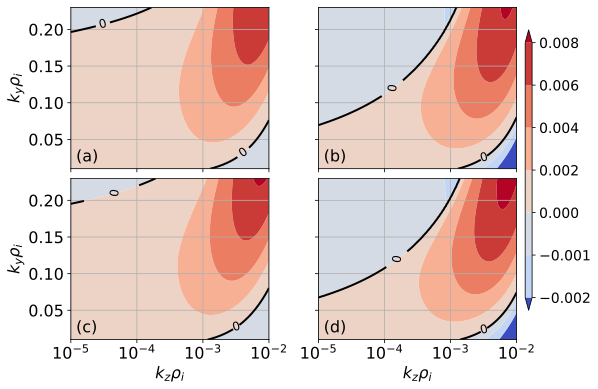

In [13]:
KZ,KY=np.meshgrid(kz_rho_i_list,ky_rho_i_list)
fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)

ax1.contourf(KZ,KY,r_M_mat,levels=levels,cmap=plt.cm.coolwarm,extend='both',norm=colors.CenteredNorm(vcenter=0))
C1 = ax1.contour(KZ,KY,r_M_mat,levels=[0.0],colors='black')
ax1.text(1.2e-5,0.02,'(a)')
ax1.set_xscale('log')
ax1.clabel(C1, inline=True, fontsize=12,manual=[(3e-5,0.21),(3e-3,0.05)])
ax1.set_ylabel(r'$k_y\rho_i$')
ax1.set_xticks(xticks,[])
ax1.set_yticks(yticks)
ax1.grid()

ax2.contourf(KZ,KY,r_MK_mat,levels=levels,cmap=plt.cm.coolwarm,extend='both',norm=colors.CenteredNorm(vcenter=0))
C2 = ax2.contour(KZ,KY,r_MK_mat,levels=[0.0],colors='black')
ax2.text(1.2e-5,0.02,'(b)')
ax2.clabel(C2, inline=True, fontsize=12,manual=[(1e-4,0.12),(3e-3,0.05)])
ax2.set_xscale('log')
ax2.set_xticks(xticks,[])
ax2.set_yticks(yticks,[])
ax2.grid()

ax3.contourf(KZ,KY,r_KM_mat,levels=levels,cmap=plt.cm.coolwarm,extend='both',norm=colors.CenteredNorm(vcenter=0))
C3 = ax3.contour(KZ,KY,r_KM_mat,levels=[0.0],colors='black')
ax3.text(1.2e-5,0.02,'(c)')
ax3.clabel(C3, inline=True, fontsize=12,manual=[(3e-5,0.21),(3e-3,0.05)])
ax3.set_xlabel(r'$k_z\rho_i$')
ax3.set_ylabel(r'$k_y\rho_i$')
ax3.set_xscale('log')
ax3.set_xticks(xticks)
ax3.set_yticks(yticks)
ax3.grid()

CB = ax4.contourf(KZ,KY,r_K_mat,levels=levels,cmap=plt.cm.coolwarm,extend='both',norm=colors.CenteredNorm(vcenter=0))
C4 = ax4.contour(KZ,KY,r_K_mat,levels=[0.0],colors='black')
ax4.text(1.2e-5,0.02,'(d)')
ax4.clabel(C4, inline=True, fontsize=12,manual=[(1e-4,0.12),(3e-3,0.05)])
ax4.set_xlabel(r'$k_z\rho_i$')
ax4.set_xscale('log')
ax4.set_xticks(xticks)
ax4.set_yticks(yticks,[])
ax4.grid()

fig.subplots_adjust(wspace=0.25,hspace=0.06)
cax = fig.add_axes([0.915, 0.178, 0.012, 0.65])
cbar=fig.colorbar(CB, cax=cax, orientation='vertical',shrink=0.8)
cbar.ax.tick_params(labelsize=14)

# plt.savefig('./fig5_gamma_vs_kyrhoi_kzrhoi.pdf', bbox_inches='tight')
plt.show()